In [88]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intro

Estimating parameters parametrizing resting state EEG data.

In [3]:
#| import files

from glob import glob
from pathlib import Path
import xarray as xr
import pandas as pd
import re
from pathlib import PosixPath
import scipy.io as sio
import numpy as np
from poirot.load_data import load_mat_file


In [68]:
#| label: "Meat of data analysis"

folder = "/Volumes/ExtremePro/Analyses/ASP0"

subs = ["S001", "S002"]
sessions = ["Session1", "Session2"]
list_y = []
d = {}
for sub in subs:
    for session in sessions:
        trials = [
            Path(p) for p in glob(f"{folder}/ASP0_{sub}_{session}_*.mat")
        ]
        for trial in trials:
            trial_number = re.findall(r"\d+", str(trial))[-1]
            iter_number = re.findall(r"\d+", str(trial))[-2]
            # display(trial_number)
            mstruct = sio.loadmat(trial)
            values = mstruct["Value"]
            # time = mstruct["Time"][0] - mstruct["Time"][0][0]
            time = np.linspace(0, 5, 3000)
            label_struct = mstruct["Atlas"][
                0, 0]["Scouts"]["Label"].ravel().tolist()
            labels = np.array([item.item() for item in label_struct])
            y = (
                xr.DataArray(
                    values.T,
                    dims= ["time", "labels"],
                    coords={
                        "labels": labels,
                        "time": time,
                        "sub": sub,
                        "session": session,
                        "iter_number": int(iter_number),
                        "trial": int(trial_number)
                    })
                .expand_dims('trial')
                .expand_dims("iter_number")
                .expand_dims("sub")
                .expand_dims("session"))
            list_y.append(y)


In [70]:
Fs = 600.
ds = xr.combine_by_coords(list_y)
ds.to_netcdf("../data/output/MEG_ASSR_times.nc")
display(ds)


<xarray.DataArray (session: 2, sub: 2, iter_number: 4, trial: 60, time: 3000,
                   labels: 68)>
array([[[[[[-1.05252277e-11, -6.41879925e-12, -3.32726806e-12, ...,
             5.05798190e-11,  3.63297892e-11,  3.86823188e-11],
           [-1.03140540e-11, -1.84683572e-12,  1.88581701e-11, ...,
             7.23760066e-11,  4.42648263e-11,  4.96196994e-11],
           [-1.13425271e-11, -3.93928169e-12,  1.46972659e-11, ...,
             1.48669408e-10,  3.59430053e-11,  3.08699476e-11],
           ...,
           [-2.48036157e-12,  2.50011001e-12, -3.72596680e-12, ...,
             1.32622445e-10, -5.49231611e-12,  3.24403987e-11],
           [ 3.04478754e-12,  5.63690722e-13, -2.38213901e-11, ...,
             1.21881127e-11, -1.44945382e-11, -1.45284515e-11],
           [-6.03422550e-13,  1.08453537e-11, -1.76638520e-11, ...,
             8.73889434e-11, -2.03525123e-11, -1.52798142e-11]],

          [[ 1.25615432e-11, -7.95202895e-12,  1.79454514e-11, ...,
            -5.26899928e-12, -7.67922891e-13,  4.06233718e-11],
           [ 5.60251813e-12, -5.38871700e-12,  1.58586807e-11, ...,
             1.07351720e-12, -1.24640743e-11,  2.58165478e-11],
           [ 1.18077878e-11, -1.94724264e-12,  2.00549591e-12, ...,
            -4.47681765e-11, -1.04338862e-11,  6.57033700e-12],
...
           [ 2.46622284e-12, -4.49227044e-12,  3.45734660e-12, ...,
            -2.85077647e-11, -1.01170394e-11,  1.30815397e-11],
           [-2.53835891e-12, -1.56440428e-12,  8.61225508e-12, ...,
            -3.02404692e-11, -1.32028503e-11, -1.34716422e-11],
           [ 2.04470348e-13, -8.05602882e-12,  7.22295339e-12, ...,
             1.42303656e-11,  6.04806220e-12, -1.41265050e-11]],

          [[ 5.80113154e-13, -9.90727695e-12,  2.12614441e-12, ...,
             8.69224174e-12,  1.20355378e-11, -1.11696129e-11],
           [ 1.57738380e-12, -3.03908449e-12,  3.49029272e-12, ...,
            -5.47702108e-11, -2.36885729e-13, -1.49642978e-11],
           [ 6.53600572e-12,  5.03585749e-12,  6.76081284e-13, ...,
            -6.45937974e-11,  1.97243930e-12, -2.16430439e-11],
           ...,
           [ 5.05189514e-12,  8.79393984e-12, -8.54553255e-12, ...,
            -7.36450367e-11, -4.57597175e-11,  2.39586246e-11],
           [-2.33849944e-12,  1.60219490e-11, -1.80787609e-11, ...,
            -1.03922940e-10, -4.51284981e-11,  1.80026231e-11],
           [-1.95448261e-12,  2.24468448e-12, -5.58972875e-12, ...,
            -4.93501501e-11, -1.54144745e-11,  1.36657878e-11]]]]]])
Coordinates:
  * labels       (labels) <U26 'bankssts L' ... 'transversetemporal R'
  * time         (time) float64 0.0 0.001667 0.003334 ... 4.997 4.998 5.0
  * sub          (sub) <U4 'S001' 'S002'
  * session      (session) <U8 'Session1' 'Session2'
  * iter_number  (iter_number) int64 1 2 3 4
  * trial        (trial) int64 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60

## Aplying function to xarray  object

In [44]:
from neurodsp.spectral import compute_spectrum, trim_spectrum
fs = 600

da = (
    ds.isel(sub=slice(0, 1))
    .dropna(dim="iter_number", how="all")
    .stack(point=["labels", "sub", "session", "iter_number", "trial"])
    .dropna(dim="point", how="all")
)
display(da)
display(da.shape)

fs = 600


#freqs, psd = compute_spectrum(da.values.T, fs, nperseg=4*fs)


<xarray.DataArray (time: 3000, point: 14144)>
array([[-1.05252277e-11,  1.25615432e-11,  1.55900336e-12, ...,
        -2.67563193e-11,  1.66879373e-11, -1.20139567e-13],
       [-1.03140540e-11,  5.60251813e-12,  7.18712469e-13, ...,
         8.44733302e-12,  3.41256780e-11,  3.16865738e-11],
       [-1.13425271e-11,  1.18077878e-11, -2.50018979e-12, ...,
         1.44999084e-11,  3.67919947e-11,  6.62268884e-12],
       ...,
       [-2.48036157e-12,  3.34009306e-14, -1.24185402e-11, ...,
         1.74603402e-11,  9.28378586e-13, -2.15951764e-11],
       [ 3.04478754e-12, -1.33322957e-12, -1.46665497e-11, ...,
         5.01432986e-12,  3.59671415e-12, -9.65856842e-12],
       [-6.03422550e-13,  3.12449844e-13, -1.30424911e-11, ...,
        -6.85246678e-13, -1.95207093e-11, -1.36585754e-11]])
Coordinates:
  * time         (time) float64 0.0 0.001667 0.003334 ... 4.997 4.998 5.0
  * point        (point) object MultiIndex
  * labels       (point) <U26 'bankssts L' ... 'transversetemporal R'
  * sub          (point) <U4 'S001' 'S001' 'S001' ... 'S001' 'S001' 'S001'
  * session      (point) <U8 'Session1' 'Session1' ... 'Session2' 'Session2'
  * iter_number  (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2
  * trial        (point) int64 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49

(3000, 14144)

In [81]:
ds = xr.open_dataarray("../data/output/MEG_ASSR_times.nc")
ds.close()

from neurodsp.spectral import compute_spectrum, trim_spectrum

import numpy as np

def as_numpy_array(func):
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return np.array(result)
    return wrapper


def my_compute_spectrum(data, fs, nperseg):
    freqs, spectrum = compute_spectrum(data, fs=fs,nperseg=nperseg)
    return  spectrum


fs = 600
test =  ds.isel(sub=slice(0, 1))

da = (
    ds.isel(sub=slice(0, 1))
    .dropna(dim="iter_number", how="all")
    .stack(point=["labels", "sub", "session", "iter_number", "trial"])
    .dropna(dim="point", how="all")
)
q = xr.apply_ufunc(
    my_compute_spectrum, ds, 
    vectorize=True,
    input_core_dims=[['time']],
    output_core_dims=[['frequency']],
    kwargs = {"fs" :fs, "nperseg":4*fs}
 
).assign_coords(frequency = lambda x: np.linspace(0,fs/2, len(x.frequency)))

display(q)

<xarray.DataArray (session: 2, sub: 2, iter_number: 4, trial: 60, labels: 68,
                   frequency: 1201)>
array([[[[[[9.06925025e-27, 4.74125817e-27, 1.27193114e-25, ...,
            2.67116963e-36, 1.53832518e-36, 1.46218531e-38],
           [7.69590896e-26, 5.13798192e-26, 7.96780130e-26, ...,
            6.62591483e-37, 2.18537961e-38, 4.36155170e-39],
           [3.26831798e-25, 1.53439889e-25, 2.27981395e-25, ...,
            2.26858968e-36, 5.29622882e-36, 2.10441153e-36],
           ...,
           [6.45098368e-25, 1.22977767e-24, 3.42294692e-23, ...,
            3.48589865e-34, 1.19383556e-34, 8.63115461e-39],
           [1.03410155e-26, 1.49761444e-28, 4.66853441e-25, ...,
            1.94428211e-35, 3.86760638e-35, 1.78011422e-35],
           [4.42379530e-25, 9.24439953e-26, 5.87696547e-24, ...,
            2.50693220e-35, 3.26387971e-35, 7.04834652e-36]],

          [[5.37425997e-27, 3.66309933e-28, 1.30412783e-26, ...,
            4.96115625e-37, 1.56397256e-36, 2.27193453e-36],
           [6.56755963e-27, 7.68322551e-28, 4.28338779e-25, ...,
            3.46303596e-37, 1.68936879e-36, 6.64980579e-38],
           [9.42576961e-26, 2.37577659e-26, 6.65196763e-25, ...,
            3.93094175e-36, 4.90028401e-36, 2.66691461e-37],
...
           [1.29789588e-24, 1.36519210e-24, 1.07577826e-23, ...,
            3.91682996e-35, 3.15734842e-35, 1.05039646e-35],
           [6.24698877e-25, 9.98598964e-26, 2.03012425e-24, ...,
            5.19391430e-36, 3.80824936e-36, 1.95025078e-36],
           [9.53192547e-25, 2.81059449e-25, 2.36414856e-24, ...,
            8.04728080e-36, 5.54875920e-36, 4.83964300e-36]],

          [[3.08463342e-26, 8.35449157e-27, 2.19383133e-25, ...,
            3.70262837e-37, 2.02441375e-37, 3.90085283e-38],
           [4.02027205e-26, 1.00792668e-26, 1.77627203e-26, ...,
            1.66399848e-37, 6.74095170e-37, 8.26708488e-37],
           [2.38448124e-25, 7.05142522e-26, 9.42146355e-25, ...,
            9.04900429e-37, 1.94742664e-36, 2.68951698e-36],
           ...,
           [8.15376822e-27, 4.62860921e-26, 1.26300605e-23, ...,
            1.15659355e-35, 8.38591548e-36, 2.88794601e-36],
           [1.73524202e-25, 1.33384330e-25, 2.44889078e-24, ...,
            1.11425542e-36, 6.47900420e-37, 3.94371821e-38],
           [5.99110454e-27, 4.20686911e-26, 2.18792037e-25, ...,
            5.96881069e-36, 3.63096565e-36, 8.25422185e-37]]]]]])
Coordinates:
  * labels       (labels) object 'bankssts L' ... 'transversetemporal R'
  * sub          (sub) object 'S001' 'S002'
  * session      (session) object 'Session1' 'Session2'
  * iter_number  (iter_number) int64 1 2 3 4
  * trial        (trial) int64 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60
  * frequency    (frequency) float64 0.0 0.25 0.5 0.75 ... 299.5 299.8 300.0

In [87]:
z = q.groupby('iter_number')
display(z)

DataArrayGroupBy, grouped over 'iter_number'
4 groups with labels 1, 2, 3, 4.

In [80]:
#display(q)
#display(q[0, :])
q[2, :].plot()


IndexError: index 2 is out of bounds for axis 0 with size 2

In [58]:
display(q)
# create a new coordinate "freq" that corresponds to the frequency bins of the PSD
freq = np.fft.fftfreq(data.time.size, np.diff(data.time)[0])
freq_bins = np.fft.rfftfreq(data.time.size, np.diff(data.time)[0])
psd_data.coords["freq"] = ("freq", freq_bins)


<xarray.DataArray (point: 14144, spectrum: 1201)>
array([[9.06925025e-27, 4.74125817e-27, 1.27193114e-25, ...,
        2.67116963e-36, 1.53832518e-36, 1.46218531e-38],
       [5.37425997e-27, 3.66309933e-28, 1.30412783e-26, ...,
        4.96115625e-37, 1.56397256e-36, 2.27193453e-36],
       [1.39792214e-25, 9.05895847e-26, 2.84518915e-25, ...,
        6.93933495e-37, 5.04006278e-38, 8.99725082e-39],
       ...,
       [1.79593477e-26, 2.89865007e-26, 9.01373565e-26, ...,
        1.39333631e-35, 3.61303994e-35, 7.78217411e-36],
       [3.37480360e-25, 1.68668338e-25, 5.49918410e-24, ...,
        2.93500072e-35, 2.65611896e-35, 1.57986096e-35],
       [1.08498483e-24, 5.18390675e-25, 1.22319028e-24, ...,
        2.02690034e-35, 8.79515715e-36, 4.46310493e-36]])
Coordinates:
  * point        (point) object MultiIndex
  * labels       (point) <U26 'bankssts L' ... 'transversetemporal R'
  * sub          (point) <U4 'S001' 'S001' 'S001' ... 'S001' 'S001' 'S001'
  * session      (point) <U8 'Session1' 'Session1' ... 'Session2' 'Session2'
  * iter_number  (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2
  * trial        (point) int64 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: spectrum

In [59]:
import numpy as np
import xarray as xr

def my_function(x, y):
    z1 = x + y
    z2 = x - y
    return {'z1': z1, 'z2': z2}

ds = xr.Dataset({'x': (('time', 'space'), np.random.randn(4, 3)),
                 'y': (('time', 'space'), np.random.randn(4, 3))},
                coords={'time': [0, 1, 2, 3],
                        'space': ['A', 'B', 'C']})

result = xr.apply_ufunc(my_function, ds['x'], ds['y'],
                        input_core_dims=[['space'], ['space']],
                        output_core_dims=[['output_dim']],
                        output_sizes={'output_dim': 2},
                        vectorize=True,
                        dask='parallelized',
                        output_dtypes=[float])


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_18361/1124666446.py:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(my_function, ds['x'], ds['y'],


AttributeError: 'dict' object has no attribute 'ndim'

In [43]:
display(q[0])
display(q[1])
da_psd = q[0]
display(da_psd [:, :, 0])
da_psd[:, :, 0].plot()

<xarray.DataArray (point: 14144, freqs: 1201)>
array([[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 2.9950e+02, 2.9975e+02,
        3.0000e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 2.9950e+02, 2.9975e+02,
        3.0000e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 2.9950e+02, 2.9975e+02,
        3.0000e+02],
       ...,
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 2.9950e+02, 2.9975e+02,
        3.0000e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 2.9950e+02, 2.9975e+02,
        3.0000e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 2.9950e+02, 2.9975e+02,
        3.0000e+02]])
Coordinates:
  * point        (point) object MultiIndex
  * labels       (point) <U26 'bankssts L' ... 'transversetemporal R'
  * sub          (point) <U4 'S001' 'S001' 'S001' ... 'S001' 'S001' 'S001'
  * session      (point) <U8 'Session1' 'Session1' ... 'Session2' 'Session2'
  * iter_number  (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2
  * trial        (point) int64 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: freqs

<xarray.DataArray (point: 14144, spectrum: 1201)>
array([[9.06925025e-27, 4.74125817e-27, 1.27193114e-25, ...,
        2.67116963e-36, 1.53832518e-36, 1.46218531e-38],
       [5.37425997e-27, 3.66309933e-28, 1.30412783e-26, ...,
        4.96115625e-37, 1.56397256e-36, 2.27193453e-36],
       [1.39792214e-25, 9.05895847e-26, 2.84518915e-25, ...,
        6.93933495e-37, 5.04006278e-38, 8.99725082e-39],
       ...,
       [1.79593477e-26, 2.89865007e-26, 9.01373565e-26, ...,
        1.39333631e-35, 3.61303994e-35, 7.78217411e-36],
       [3.37480360e-25, 1.68668338e-25, 5.49918410e-24, ...,
        2.93500072e-35, 2.65611896e-35, 1.57986096e-35],
       [1.08498483e-24, 5.18390675e-25, 1.22319028e-24, ...,
        2.02690034e-35, 8.79515715e-36, 4.46310493e-36]])
Coordinates:
  * point        (point) object MultiIndex
  * labels       (point) <U26 'bankssts L' ... 'transversetemporal R'
  * sub          (point) <U4 'S001' 'S001' 'S001' ... 'S001' 'S001' 'S001'
  * session      (point) <U8 'Session1' 'Session1' ... 'Session2' 'Session2'
  * iter_number  (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2
  * trial        (point) int64 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: spectrum

IndexError: too many indices

In [ ]:
from neurodsp.spectral import compute_spectrum, trim_spectrum
da = (
    ds.isel(sub=slice(0, 1))
    .dropna(dim="iter_number", how="all")
    .stack(point=["labels", "sub", "session", "iter_number", "trial"])
    .dropna(dim="point", how="all")
)
display(da)
display(da.shape)

fs = 600

freqs, psd = compute_spectrum(da.values.T, fs, nperseg=4*fs)


In [27]:
varr = da
fs = 600
nperseg = 4*fs
_T = nperseg
ns = _T // 2 + 1
if _T % 2 == 0:
    freq_crd = np.linspace(0, 0.5, ns)
else:
    freq_crd = np.linspace(0, 0.5 * (_T - 1) / _T, ns)


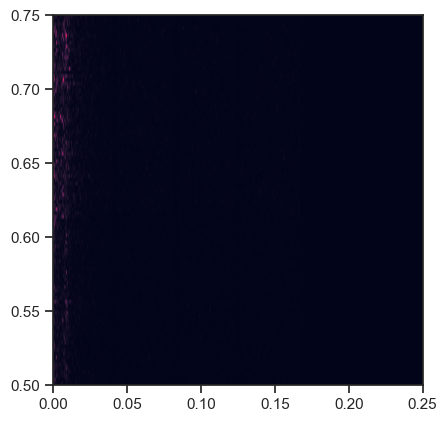

In [23]:
import matplotlib.pyplot as plt
plt.imshow(psd[0:100, :], extent=freqs)


<xarray.DataArray (labels: 68, time: 3000)>
array([[-1.05252277e-11, -1.03140540e-11, -1.13425271e-11, ...,
        -2.48036157e-12,  3.04478754e-12, -6.03422550e-13],
       [-6.41879925e-12, -1.84683572e-12, -3.93928169e-12, ...,
         2.50011001e-12,  5.63690722e-13,  1.08453537e-11],
       [-3.32726806e-12,  1.88581701e-11,  1.46972659e-11, ...,
        -3.72596680e-12, -2.38213901e-11, -1.76638520e-11],
       ...,
       [ 5.05798190e-11,  7.23760066e-11,  1.48669408e-10, ...,
         1.32622445e-10,  1.21881127e-11,  8.73889434e-11],
       [ 3.63297892e-11,  4.42648263e-11,  3.59430053e-11, ...,
        -5.49231611e-12, -1.44945382e-11, -2.03525123e-11],
       [ 3.86823188e-11,  4.96196994e-11,  3.08699476e-11, ...,
         3.24403987e-11, -1.45284515e-11, -1.52798142e-11]])
Coordinates:
  * labels       (labels) <U26 'bankssts L' ... 'transversetemporal R'
  * time         (time) float64 0.0 0.001667 0.003334 ... 4.997 4.998 5.0
    point        object ('S001', 'Session1', 1, 1)
    sub          <U4 'S001'
    session      <U8 'Session1'
    iter_number  int64 1
    trial        int64 1

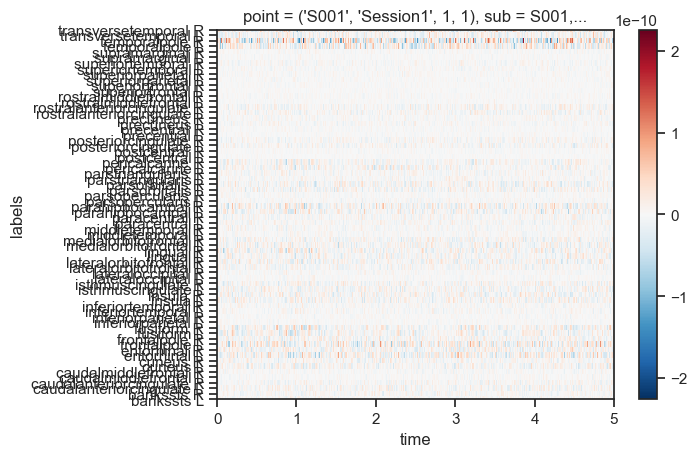

In [11]:
display(da[:, :, 0])
da[:, :, 0].plot()


In [47]:
import numpy as np
import xarray as xr

# create some random data and put it into an xarray dataset
data = xr.Dataset(
    {
        "temperature": (("time", "depth"), np.random.rand(100, 10)),
    },
    coords={
        "time": np.arange("2000-01-01", "2000-04-10", dtype="datetime64[D]"),
        "depth": np.linspace(0, 1, 10),
    },
)

# define the function to compute the PSD


def psd(x):
    # apply a hanning window to the data
    x = x * np.hanning(len(x))
    # compute the FFT
    xf = np.fft.rfft(x)
    # compute the power spectrum density
    return np.real(xf * np.conj(xf))


# apply the ufunc "psd" over the "time" dimension of the temperature variable in the dataset
psd_data = xr.apply_ufunc(psd, data.temperature, input_core_dims=[
                          ["time"]], output_core_dims=[["freq"]])

# create a new coordinate "freq" that corresponds to the frequency bins of the PSD
freq = np.fft.fftfreq(data.time.size, np.diff(data.time)[0])
freq_bins = np.fft.rfftfreq(data.time.size, np.diff(data.time)[0])
psd_data.coords["freq"] = ("freq", freq_bins)

# plot the result
psd_data.plot(x="freq")


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_84732/544089405.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data = xr.Dataset(


ValueError: operands could not be broadcast together with shapes (10,100) (10,) 

In [49]:
import numpy as np
import xarray as xr

# create some random data and put it into an xarray dataset
data = xr.Dataset(
    {
        "temperature": (("depth", "time"), np.random.rand(10, 100)),
    },
    coords={
        "depth": np.linspace(0, 1, 10),
        "time": np.arange("2000-01-01", "2000-04-10", dtype="datetime64[D]"),
    },
)

# define the function to compute the PSD


def psd(x):
    # apply a hanning window to the data
    x = x * np.hanning(len(x))
    # compute the FFT
    xf = np.fft.rfft(x)
    # compute the power spectrum density
    return np.real(xf * np.conj(xf))


# add a new dimension to the time coordinate using np.newaxis
psd_data = xr.apply_ufunc(psd, data.temperature, input_core_dims=[["time"]], output_core_dims=[["freq"]], keep_attrs=True,
                          **{'dask': 'parallelized', 'output_dtypes': [data.temperature.dtype], })
psd_data.coords['time'] = data.time.values[:, np.newaxis]

# create a new coordinate "freq" that corresponds to the frequency bins of the PSD
freq_bins = np.fft.rfftfreq(data.time.size, np.diff(data.time)[0])
psd_data.coords["freq"] = ("freq", freq_bins)

# plot the result
psd_data.plot(x="freq", y="depth")


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_84732/356315902.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data = xr.Dataset(


ValueError: operands could not be broadcast together with shapes (10,100) (10,) 